# Raw data processing
- conversion time --> %coupe
- data filtering
- data downsampling

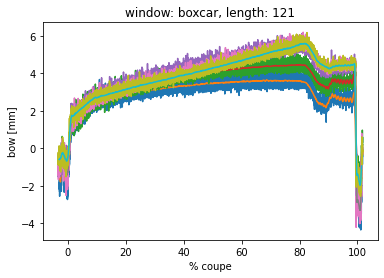

In [7]:
from scipy import signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# get the two values temps_contact and Durée_effective_coupe
dg = pd.read_excel(r'C:\Users\franc\OneDrive\Bureau\confocal1\Bow_Coupe_117.xlsx',
                  sheet_name ='2019-10-01_Bow_mm', skiprows = 3, header = None, usecols='F:G',nrows=2,)

cst = dg.to_dict(orient='split')['data']
temps_contact = cst[0][1] # in sec
Durée_effective_coupe = cst[1][1] # in min

# get the data
data = pd.read_excel(r'C:\Users\franc\OneDrive\Bureau\confocal1\Bow_Coupe_117.xlsx',
                  sheet_name ='2019-10-01_Bow_mm', skiprows = 5,  usecols='B,H,I,J,K,L')

# conversion time --> cut percentage 
per_cent_coupe = np.array(data['Temps LabView (s)'])
per_cent_coupe = 100* (per_cent_coupe - per_cent_coupe[0] - temps_contact)/(60*Durée_effective_coupe)

# filter the data using a moving window of length long and of type win
long = 121
win ='boxcar'  #'hamming', 'boxcar', 'boxcar','triang', 'blackman', 'hamming', 'bartlett', 'parzen', 'bohman',
norme = sum(signal.get_window(win, long))
dic = {}
bow_name = [x for x in data.columns if 'Bow' in x]
for bow in bow_name:
    data_filter = data[bow].rolling(long,center=True, win_type=win, axis=0).sum()/norme
    plt.plot(per_cent_coupe,data[bow])
    plt.plot(per_cent_coupe,data_filter)
    dic[bow] = data_filter[long//2+1::long]
plt.xlabel('% coupe')
plt.ylabel('bow [mm]')
plt.title(f'window: {win}, length: {long}')
dic['% coupe'] = per_cent_coupe[long//2+1::long]
new = pd.DataFrame.from_dict(dic)
new=new.reindex(columns= ['% coupe', *bow_name])

new.to_excel(r'C:\Users\franc\OneDrive\Bureau\confocal1\result.xlsx')

# Comparison with INES processing

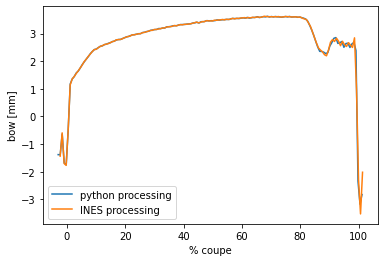

In [8]:
dines = df = pd.read_excel(r'C:\Users\franc\OneDrive\Bureau\confocal1\Bow_Coupe_117.xlsx',
                  sheet_name ='2019-10-01_Bow&dérivée', header = 5, usecols='G,H,J,L,N,P')
plt.plot(dic['% coupe'],dic['Bow 8 (mm)'],label ='python processing')
plt.plot(dines['% coupe'],dines['Bow 8 lissé (mm)'],label ='INES processing')
plt.xlabel('% coupe')
plt.ylabel('bow [mm]')
plt.legend()

# 3D plot

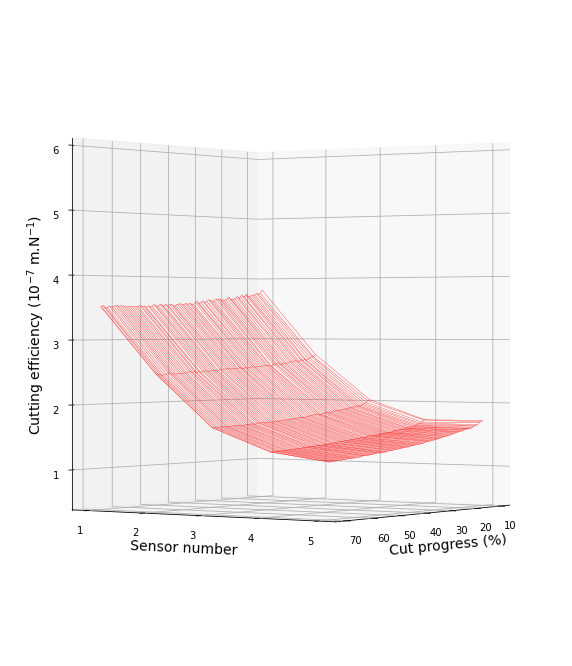

In [6]:
## version 25/11/2020
import pandas as pd
import numpy as np
from pathlib import Path #<----------------------------- work with Python 4
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
from scipy import interpolate

#Loading data
Num_coupe = 118

data_folder = Path("C:/Users/franc/OneDrive/Bureau/confocal1") #<------------------- uses mac & Unix convention data_file = 'Kappa 3D_Coupe_'+str(Num_coupe)+'.xlsx'
df_raw = pd.read_excel(data_folder / Path("Kappa 3D_Coupe_118.xlsx")) # <--------- work with all os df_raw.columns=['A
df_raw.rename({"% coupe":"A"}, axis=1, inplace=True)


#Real measurements values
val_min = 10
val_max = 70
df= df_raw.query('A > @val_min and A < @val_max') 

y1 = list(df['A'])                # % of cut
x1 =[1,2,3,4,5]                   # Sensor number
x,y = np.meshgrid(x1, y1)         # (x,y) mesh construction 
df=df.drop(['A'],axis=1)          # Keep only z values in df
z = df.values                     # 2D array of z values
 
fig = plt.figure(figsize=(10,12)) # Plot area 
ax = plt.axes(projection="3d")    # Frame for 3D plot
 
# interpolation 
newfunc = interpolate.interp2d(x1,y1,z,kind='linear')         # Definition of 2D linear interpolation function 
xnew = np.linspace(x1[0] , x1[-1], num=1000, endpoint=True)   # New sampling of 1000 points along x between extrema of x1 
ynew = np.linspace(y1[0] , y1[-1], num=1000, endpoint=True)   # New sampling of 1000 points along y between extrema of y1 
znew = newfunc(xnew, ynew)                                    # Use of the defined newfunc as 2D linear interpolation 
                                                              # for the calculation of z at the (xnew,ynew) positions 
x,y = np.meshgrid(xnew, ynew)                                 # (x,y) mesh re-construction for the (xnew,ynew) positions

# 3D plot
surf=ax.plot_wireframe(y, x, znew, 0.3, rcount=len(y1), ccount=4, color='red')                # Wireframe 


ax.set_zlim(0.5, 6)                                                     # set limits of z axis
ax.set_yticks(x1, minor=False)                                          # set ticks label for y axis (integer values)
ax.set_ylabel('Sensor number',fontsize=14)                              # set label of y axis
ax.set_xlabel('Cut progress (%)',fontsize=14)                           # set label of x axis
ax.set_zlabel('Cutting efficiency (10$^{-7}$ m.N$^{-1}$)',fontsize=14)  # set label of z axis
ax.view_init(elev=0., azim=35)                                          # set point of view
